In [ ]:
import time
import sys
import os
from PIL import Image
import numpy as np
import cv2


import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing import image
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Dense, Activation,Dropout,Conv2D, MaxPooling2D,BatchNormalization, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model, load_model, Sequential
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow

import warnings
warnings.simplefilter("ignore")

## Problem Statement
Image classification is an exciting subclass of computer vision.  The purpose of this project is to examine if a deep learning model can be created to accurately classify lung tissue histopathological images into one of three classes: adenocarcinoma, squamous cell carcinoma, or benign. If successful, the model could be used as both a pre-screener and post-screener for the images. Pre-screening could be performed immediately after the image was developed (before being viewed by a doctor or medical professional) and could flag images that need immediate review. Post-screening images (after images are classified by a doctor or medical professional) could ensure that the classification is consistent.

This project will create and evaluate the following three deep learning models to examine if they can be used to classify lung tissue images with high accuracy: 
1. A Convolutional neural network (CNN) model built from scratch using Keras.  
2. A CNN model built on top of the ResNet50 model architecture using the fastai library.
3. A CNN model built on top of the VGG19 model architecture using the fastai library.

In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Thu Nov 18 23:25:58 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   42C    P0    29W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Dataset used in this project.

---

The [histopathological images](https://en.wikipedia.org/wiki/Histopathology) used for this project are in three classes: lung adenocarcinoma (lung_aca), lung squamous cell carcinomas (lung_scc),  and lung benign (lung_benign). The images used in the project can be downloaded from [google drive](https://drive.google.com/drive/folders/14tG6gHRl0exJANZg3xa6JFUT1Xi8RH-a). The dataset was originally downloaded from [Kaggle](https://www.kaggle.com/andrewmvd/lung-and-colon-cancer-histopathological-images).

Let's examine how many images are in each folder for the three classes. 

In [ ]:
train_dir = '/content/drive/MyDrive/Lung and Colon cancer images/train_lung_image_sets'
labels = os.listdir(train_dir)
print("No. of labels in the Training set: {}".format(len(labels)))
print("-----------------")
os.chdir(train_dir)
for label in labels:
    print("{}, {} files".format(label, len(os.listdir(train_dir+ '//' +label))))


No. of labels in the Training set: 3
-----------------
lung_scc, 5000 files
lung_aca, 5000 files
lung_benign, 5000 files


Next, we will plot 10 images from the lung squamous cell carcinomas .

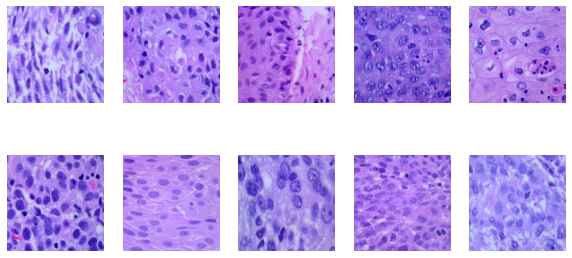

In [ ]:
lung_scc = '/content/drive/MyDrive/Lung and Colon cancer images/train_lung_image_sets/lung_scc'
sub_class = os.listdir(lung_scc)

fig = plt.figure(figsize=(10,5))
for e in range(len(sub_class[:10])):
    plt.subplot(2,5,e+1)
    img = plt.imread(os.path.join(lung_scc,sub_class[e]))
    plt.imshow(img, cmap=plt.get_cmap('gray'))
    plt.axis('off')

### Data Augmentation.

---
Since this dataset already contains augmented images, so further data augmentation will not be required.  
We will use the ImageDataGenerator class from Keras to split the data into training and validation sets.

In [ ]:
img_datagen = ImageDataGenerator(rescale=1./255,
                                 validation_split=0.2)
                                
#test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = img_datagen.flow_from_directory(train_dir,
                                                 shuffle=True,
                                                 batch_size=32,
                                                 subset='training',
                                                 target_size=(100,100))
                                                 
valid_generator = img_datagen.flow_from_directory(train_dir,
                                                 shuffle=True,
                                                 batch_size=16,
                                                 subset='validation',
                                                 target_size=(100,100))

# Create a lablel_map dictionary that we will use for predicting on unseen data
label_map = (train_generator.class_indices)
print('Label mappings:\n')
label_map

Found 12000 images belonging to 3 classes.
Found 3000 images belonging to 3 classes.
Label mappings:



{'lung_aca': 0, 'lung_benign': 1, 'lung_scc': 2}

## Creating a baseline CNN model using Keras.

---

Next, we will instantiate a Sequential model and add 6 convolutional and maxpooling layers. We will also add three dropout layers to avoid overfitting. . 

In [ ]:
model = Sequential()
model.add(Conv2D(filters=32, kernel_size=(3,3),input_shape=(100,100,3), activation='relu', padding = 'same'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(filters=64, kernel_size=(3,3), activation='relu', padding = 'same'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(filters=64, kernel_size=(3,3), activation='relu', padding = 'same'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(filters=64, kernel_size=(3,3), activation='relu', padding = 'same'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(filters=64, kernel_size=(3,3), activation='relu', padding = 'same'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.3))

model.add(Conv2D(filters=64, kernel_size=(3,3), activation='relu', padding = 'same'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())

model.add(Dense(256))
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Dense(len(label_map)))
model.add(Activation('softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 100, 100, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 50, 50, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 50, 50, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 25, 25, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 25, 25, 64)        36928     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 12, 12, 64)       0

To avoid overfitting, we will use the EarlyStopping class to monitor the validation accuracy and stop training the model if the accuracy does not improve after more than 4 epochs (patience=4).

In [ ]:
callbacks_list = [EarlyStopping( monitor='accuracy', patience=4, ),
                  ModelCheckpoint( filepath='/content/drive/MyDrive/train results/models/keras_lung_cancer_tumor_classification_model.h5',
                                  monitor='val_accuracy', save_best_only=True, ) ]


Next, we compile the model using the adam optimizer and the categoical_crossentropy loss function since this is a multi-class classification problem.

In [ ]:
model.compile(optimizer='adam',
             loss='categorical_crossentropy',
             metrics=['accuracy'])

In [ ]:
history = model.fit(train_generator, validation_data=valid_generator,
                   steps_per_epoch=train_generator.n//train_generator.batch_size,
                   validation_steps=valid_generator.n//valid_generator.batch_size,
                    callbacks=[callbacks_list],
                    epochs=50)

Epoch 1/50
375/375 [==============================] - 2746s 7s/step - loss: 0.4632 - accuracy: 0.7740 - val_loss: 0.2355 - val_accuracy: 0.9121
Epoch 2/50
375/375 [==============================] - 138s 368ms/step - loss: 0.2596 - accuracy: 0.9045 - val_loss: 0.2957 - val_accuracy: 0.8844
Epoch 3/50
375/375 [==============================] - 137s 367ms/step - loss: 0.2173 - accuracy: 0.9188 - val_loss: 0.1560 - val_accuracy: 0.9405
Epoch 4/50
375/375 [==============================] - 137s 367ms/step - loss: 0.1718 - accuracy: 0.9373 - val_loss: 0.1707 - val_accuracy: 0.9318
Epoch 5/50
375/375 [==============================] - 137s 366ms/step - loss: 0.1648 - accuracy: 0.9398 - val_loss: 0.1373 - val_accuracy: 0.9489
Epoch 6/50
375/375 [==============================] - 137s 364ms/step - loss: 0.1341 - accuracy: 0.9513 - val_loss: 0.1129 - val_accuracy: 0.9606
Epoch 7/50
375/375 [==============================] - 137s 367ms/step - loss: 0.1202 - accuracy: 0.9545 - val_loss: 0.1300 - v

### Plotting baseline model training and validation curves.

---
Next, we will plot the training and validation accuracy and loss curves.

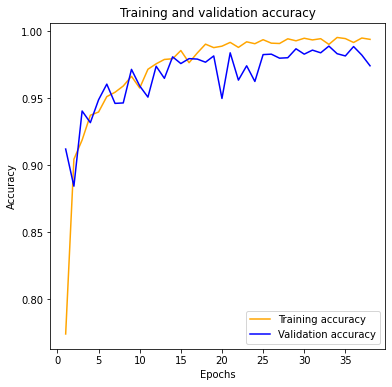

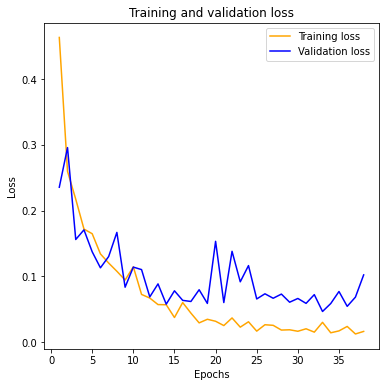

In [ ]:
training_accuracy = history.history['accuracy']
validation_accuracy = history.history['val_accuracy']

training_loss = history.history['loss']
validation_loss = history.history['val_loss']

epochs = range(1, len(training_accuracy) + 1)
plt.figure(figsize=(6,6))
plt.plot(epochs, training_accuracy, 'orange', label='Training accuracy')
plt.plot(epochs, validation_accuracy, 'b', label='Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure(figsize=(6,6))

plt.plot(epochs, training_loss, 'orange', label='Training loss')
plt.plot(epochs, validation_loss, 'b', label='Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()


From the above training and validation curves, we can see that the validation scores are better than the training scores across almost all epochs. This is likely due to the two dropout layers in the model. The dropout layers prevent all of the nodes from being used during training, but the nodes are fully available during validation. Next, we will make predictions with the best performing model that was saved during early stopping.

In [ ]:
model.save('/content/drive/MyDrive/train results/models/keras_lung_cancer_tumor_classification_model.h5')

## Building a model on top of the ResNet50 model architecture.

---
Next, we will use the fastai library to build a model on top of the pretrained ResNet50 model. First we import the fastai library and setup the data using the ImageDataBunch.from_folder function. This function automatically infers the class names. We can also perform image augmentation if necessary, setup the validation set, image size, and batch size.

In [ ]:
from fastai.vision import *
from fastai.widgets import *

data = ImageDataBunch.from_folder(
    train_dir,
    valid_pct=0.2,
    ds_tfms=get_transforms(do_flip=False),
    size=100,
    num_workers=8,
    bs=64
)

data.normalize(imagenet_stats)

ImageDataBunch;

Train: LabelList (12000 items)
x: ImageList
Image (3, 100, 100),Image (3, 100, 100),Image (3, 100, 100),Image (3, 100, 100),Image (3, 100, 100)
y: CategoryList
lung_scc,lung_scc,lung_scc,lung_scc,lung_scc
Path: /content/drive/MyDrive/Lung and Colon cancer images/train_lung_image_sets;

Valid: LabelList (3000 items)
x: ImageList
Image (3, 100, 100),Image (3, 100, 100),Image (3, 100, 100),Image (3, 100, 100),Image (3, 100, 100)
y: CategoryList
lung_aca,lung_benign,lung_scc,lung_scc,lung_benign
Path: /content/drive/MyDrive/Lung and Colon cancer images/train_lung_image_sets;

Test: None

Next, we will use the show_batch function to show some of the images.

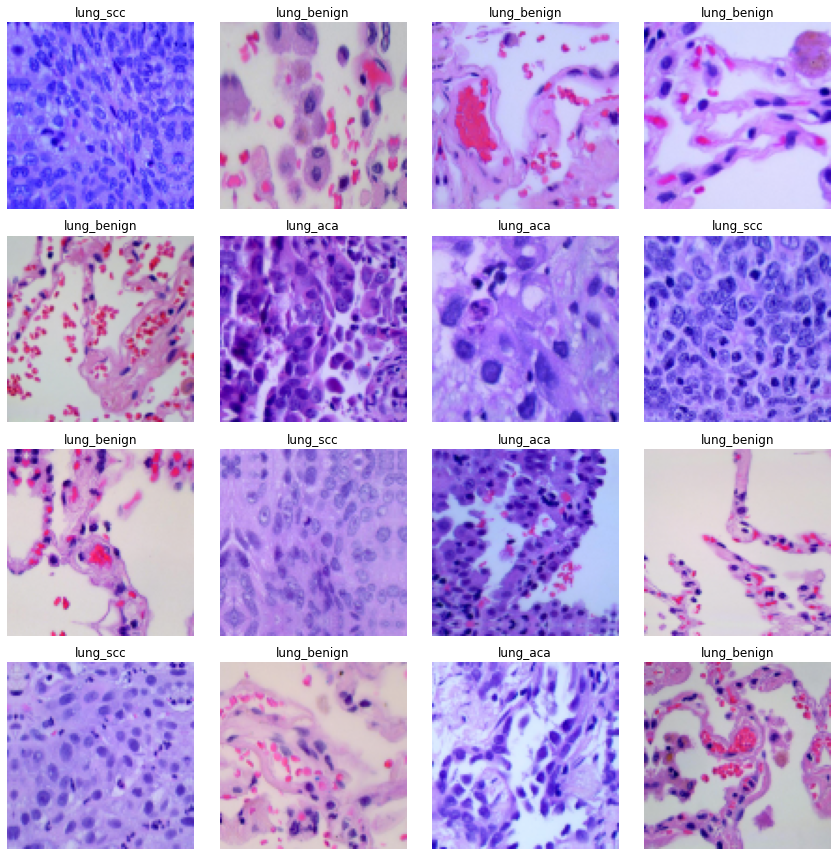

In [ ]:
data.show_batch(rows=4, figsize=(12,12))

### Downloading and using the ResNet50 model.

---
Next, we will load the resnet50 model, and train the model on the dataset for 4 epochs.

In [ ]:
learn = cnn_learner(data, models.resnet50, metrics=accuracy)

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

In [ ]:
learn.fit_one_cycle(4)

epoch,train_loss,valid_loss,accuracy,time
0,0.279818,0.126537,0.950000,07:01
1,0.158300,0.076736,0.970333,02:30
2,0.107816,0.061529,0.975333,02:29
3,0.080930,0.042411,0.984667,02:29


### Adding layers on top of the ResNet50 model architecture.

---
From above, we can see that we achieved a 98.4% accuracy without any tuning of the model.  
Next, we will unfreeze the top layers of ResNet50, and find an optimal learning rate. 

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 9.12E-07
Min loss divided by 10: 5.75E-07


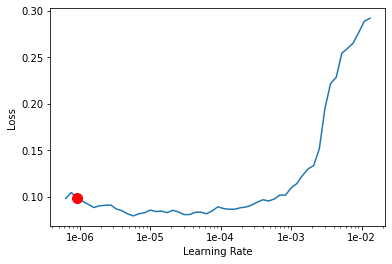

In [ ]:
learn.unfreeze()
learn.lr_find()
learn.recorder.plot(suggestion=True)

### Adjusting the learning rate for the ResNet50 model.

---
Looking at the graph, we will vary the learning rate between 1e-06 to 1e-04. (the early layers will have a maximum lr of 1e-06 and the deepest layers will have 1e-04 as their max_lr). We will use the slice function and to vary the learning rate and fit the model for 5 epochs.

In [ ]:
learn.fit_one_cycle(5, slice(1e-06,1e-04))

epoch,train_loss,valid_loss,accuracy,time
0,0.036713,0.012559,0.996333,02:30
1,0.028097,0.009652,0.997000,02:29
2,0.023177,0.006504,0.998000,02:29
3,0.016902,0.005744,0.998333,02:29
4,0.018530,0.005179,0.998667,02:29


The tuned model produced an accuracy rate of 99.86%. We will save the model.

In [ ]:
learn.save("/content/drive/MyDrive/train results/models/fastai_lung_cancer_resnet50_model")

### Downloading and using the VGG19 model.

---
Next, we will load the VGG19 model, and train the model on the dataset for 3 epochs.

In [ ]:
learn_vgg = cnn_learner(data, models.vgg19_bn, metrics=accuracy)

In [ ]:
learn_vgg.fit_one_cycle(3)

epoch,train_loss,valid_loss,accuracy,time
0,0.267053,0.126885,0.953333,02:27
1,0.188909,0.113993,0.954667,02:26
2,0.127109,0.085310,0.967667,02:27


### Adding layers on top of the VGG19 model architecture.

---
From above, we can see that we achieved almost 96.8% accuracy without any tuning of the model.  
Next, we will unfreeze the top layers of VGG19, and find an optimal learning rate. 

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 8.32E-06
Min loss divided by 10: 1.32E-07


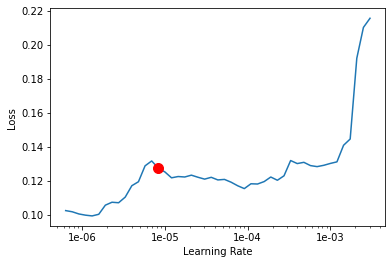

In [ ]:
learn_vgg.unfreeze()
learn_vgg.lr_find()
learn_vgg.recorder.plot(suggestion=True)

### Adjusting the learning rate for the VGG19 model.

---
Looking at the graph, we will vary the learning rate between 1e-05 to 1e-04. (the early layers will have a maximum lr of 1e-05 and the deepest layers will have 1e-04 as their max_lr). We will use the slice function and to vary the learning rate and fit the model for 4 epochs.

In [ ]:
learn_vgg.fit_one_cycle(4, slice(1e-05,1e-04))

epoch,train_loss,valid_loss,accuracy,time
0,0.085355,0.046856,0.983000,02:28
1,0.055793,0.021286,0.992667,02:27
2,0.027965,0.012579,0.997333,02:30
3,0.022911,0.008244,0.999000,02:31


### Plotting the confusion matrix of the final fastai VGG19 model.
---

In [ ]:
interp_vgg = ClassificationInterpretation.from_learner(learn_vgg)

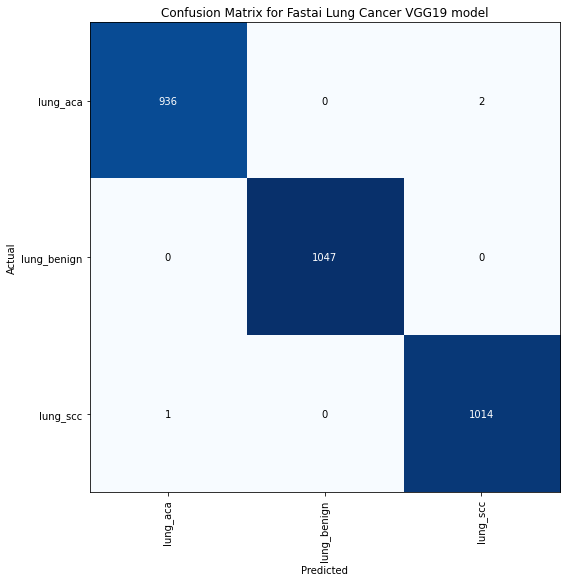

In [ ]:
interp_vgg.plot_confusion_matrix(figsize=(8,8),
                                 title='Confusion Matrix for Fastai Lung Cancer VGG19 model')

The model accuracy increaded to 99.9%, and in fact the model only misclassified 3 images.  
Next, we will save the model and plot the images with the highest losses.

In [ ]:
learn_vgg.save("/content/drive/MyDrive/train results/models/fastai_lung_cancer_vgg19_model")

### Plotting images with the highest losses.

---
Next, we can plot the images that had the highest loss values to examine them.

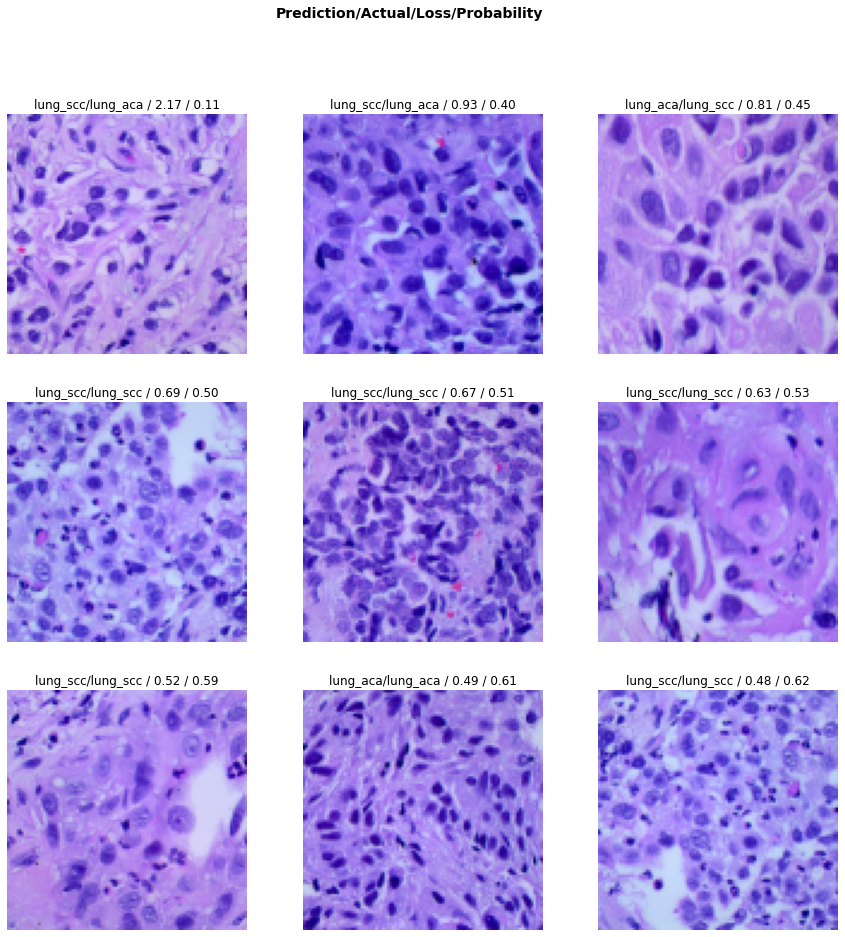

In [ ]:
interp_vgg.plot_top_losses(9, figsize=(15,15))


Using the above images, a domain expert could examine them to see if they can identify if they were truly incorrect classifications, or if the images were mislabeled. If the images were incorrectly labeled, then fastai has a function called from_toplosses() function that allows images with the highest loss values to be manually re-labeled.

### Conclusions.

---
  
To recap, we first built a CNN from scratch in Keras and achieved a validation accuracy of 97.3%. Then, we used the fastai library to build a baseline model on top of the ResNet50 model and achieved a validation accuracy of 98.4%. We then tuned the model and the validation accuracy increased to 99.8%. 

Next, we built build a baseline model on top of the VGG19 model and achieved a validation accuracy of 96.7%. We then tuned the model and the validation accuracy increased to 99.9%. 

The results indicate that the models could be a useful tool for pre-screening or post-screening cancer images, as long as the cancer is one of the previously identified cancer types.

### Limitations.

---
As with any use case for machine learning in medicine, we need to remember that a model’s prediction is no substitute for the diagnosis of a trained medical professional. Therefore, machine learning should only be used in conjunction with the diagnosis of a medical professional, rather than as a unilateral method of diagnosis. Additionally, the models can only identify the images of cancers that they have been trained on, so any new cancers would not be correctly classified.  